In [1]:
import torch
import torchvision
import torch.utils
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.models import vgg19, VGG19_Weights
from torchvision.transforms import transforms
import torchvision.datasets as datasets
from torch.utils.data import Subset,DataLoader
from torch.utils.data import Dataset
from torchvision.utils import make_grid, save_image
import os

In [2]:
save_dir = r"C:\Users\maddo\Downloads\SUPER RESOLUTION GAN AND ANOGAN"  # <-- added
os.makedirs(save_dir, exist_ok=True)

In [3]:
vgg = vgg19(weights=VGG19_Weights.IMAGENET1K_V1)

In [4]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [5]:
x=torch.rand(3,10)

In [6]:
poo=nn.Linear(10,10)

In [7]:
layer=[]

In [8]:
layer+=[nn.Linear(10,10),nn.ReLU()]

In [9]:
ha=nn.Sequential(*layer)

In [10]:

ya=ha(x)

In [11]:
ya

tensor([[0.0406, 0.1496, 0.0000, 0.3120, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.1337, 0.2802, 0.0000, 0.2249, 0.0000, 0.0000, 0.0000, 0.0517, 0.0000,
         0.0000],
        [0.0467, 0.3903, 0.0000, 0.0000, 0.0000, 0.0000, 0.1240, 0.1179, 0.0000,
         0.0000]], grad_fn=<ReluBackward0>)

In [12]:
class Resblocks(nn.Module):
    def __init__(self,channel=64):
        super().__init__()
        self.cv1=nn.Conv2d(in_channels=channel,out_channels=channel,kernel_size=3,padding=1,stride=1)
        self.cv2=nn.Conv2d(in_channels=channel,out_channels=channel,kernel_size=3,padding=1,stride=1)
        self.prelu=nn.PReLU()
        self.bn1=nn.BatchNorm2d(channel)
        self.bn2=nn.BatchNorm2d(channel)
    def forward(self,x):
        out=self.cv1(x)
        out=self.bn1(out)
        out=self.prelu(out)
        out=self.cv2(out)
        out=self.bn2(out)
        out=self.prelu(out)
        return x+out
        
        

In [13]:
class SRGenerator(nn.Module):
    def __init__(self,channel=64):
        super().__init__()
        self.firstcv=nn.Conv2d(in_channels=3,out_channels=channel,kernel_size=5,padding=2,stride=1)
        self.midcv=nn.Sequential(*(Resblocks(channel) for _ in range(16)))
        self.prelu=nn.PReLU()
        self.bnmid=nn.BatchNorm2d(channel)
        self.up1=nn.Conv2d(in_channels=channel,out_channels=channel*4,kernel_size=3,padding=1,stride=1)
        self.pixshuf=nn.PixelShuffle(upscale_factor=2)
        self.up2=nn.Conv2d(in_channels=channel,out_channels=channel*4,kernel_size=3,padding=1,stride=1)
        self.finalconv=nn.Conv2d(in_channels=channel,out_channels=3,kernel_size=3,padding=1,stride=1)
    def forward(self,x):
        out=self.firstcv(x)
        res=self.prelu(out)
        res=self.midcv(res)
        res=self.bnmid(res)
        outfinal=out+res
        final=self.pixshuf(self.up1(outfinal))
        final=self.prelu(final)
        final=self.prelu(self.pixshuf(self.up2(final)))
        final=self.finalconv(final)
        return final 
        
        
        
        





In [14]:
class critic(nn.Module):
    def __init__(self):
        super().__init__()
        self.cn1=nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,padding=1,stride=1)
        self.bn1=nn.BatchNorm2d(32)
        self.cn2=nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,padding=1,stride=2)
        self.bn2=nn.BatchNorm2d(64)
        self.cn3=nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,padding=1,stride=1)
        self.bn3=nn.BatchNorm2d(128)
        self.cn4=nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,padding=1,stride=2)
        self.bn4=nn.BatchNorm2d(256)
        self.cn5=nn.Conv2d(in_channels=256,out_channels=512,kernel_size=3,padding=1,stride=1)
        self.bn5=nn.BatchNorm2d(512)
        self.fc1=nn.Linear(512*32*32,1024)
        self.leaky_relu=nn.LeakyReLU(0.2,inplace=True)
        self.fc2=nn.Linear(1024,1)
        self.flat=nn.Flatten()

    def forward(self,x):
        out=self.bn1(self.cn1(x))
        out=self.leaky_relu(out)
        out=self.bn2(self.cn2(out))
        out=self.leaky_relu(out)
        out=self.bn3(self.cn3(out))
        out=self.leaky_relu(out)
        out=self.bn4(self.cn4(out))
        out=self.leaky_relu(out)
        out=self.bn5(self.cn5(out))
        #print(out.shape)
        lul=self.flat(out)
        #print(lul.shape)
        ha=self.fc1(lul)
        #print(ha.shape)
        ha=self.leaky_relu(ha)
        ha=self.fc2(ha)
        return ha
        
        

In [15]:
res=Resblocks()

In [16]:
ka=torch.randn(10,64,28,28)

In [17]:
out=res(ka)

In [18]:
out.shape

torch.Size([10, 64, 28, 28])

In [19]:
ha=SRGenerator()

In [20]:
haa=torch.randn(10,3,28,28)

In [21]:
paa=ha(haa)

In [22]:
paa.shape

torch.Size([10, 3, 112, 112])

In [23]:
print(ha)

SRGenerator(
  (firstcv): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (midcv): Sequential(
    (0): Resblocks(
      (cv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (cv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (prelu): PReLU(num_parameters=1)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Resblocks(
      (cv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (cv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (prelu): PReLU(num_parameters=1)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Resblocks(
      (cv1): Conv2d(64, 64, kernel_size=(3, 3), 

In [24]:
dic=critic()

In [25]:
print(dic)

critic(
  (cn1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (cn2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (cn3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (cn4): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (cn5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=524288, out_features=1024, bias=True)
  (leaky_relu): LeakyReLU(negative_slope=0.2, inplace=True)
  (fc2): Linear(in_features=1024, out_f

In [26]:
x=torch.randn(16,3,128,128)

In [27]:
ha=dic(x)

In [28]:
ha.shape

torch.Size([16, 1])

In [29]:
kek=vgg(x)

In [30]:
ha=nn.Sequential(*list(vgg.features.children())[:20])

In [31]:
print(ha)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [32]:
paa=ha(x)

In [33]:
paa.shape

torch.Size([16, 512, 16, 16])

In [34]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ,transforms.Resize((128, 128))
])

In [35]:
train_dataset=datasets.CelebA(root="C:/Users/maddo/Downloads/COdes from Work/Working on now",split='train',target_type='attr',transform=transform,download=True)

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99058187..1.0].


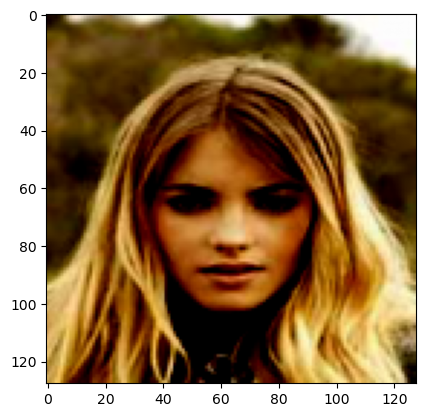

In [36]:
plt.imshow(train_dataset[18][0].permute(1, 2, 0))

In [37]:
transformlowres = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ,transforms.Resize((32, 32))
])

In [38]:
test_dataset=datasets.CelebA(root="C:/Users/maddo/Downloads/COdes from Work/Working on now",split='train',target_type='attr',transform=transformlowres,download=True)

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.80674994..0.9978436].


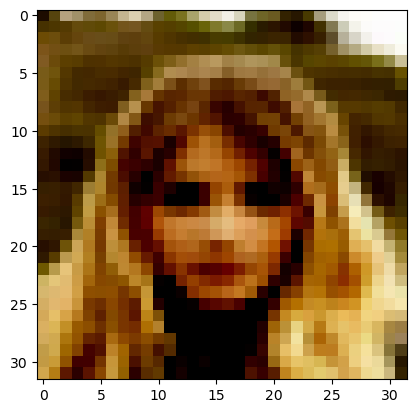

In [39]:
plt.imshow(test_dataset[18][0].permute(1, 2, 0))

In [40]:
class CustomImageDataset(Dataset):
    def __init__(self,traindata,testdata):
        self.test=testdata
        self.train=traindata

    def __len__(self):
        return len(self.test)

    def __getitem__(self, idx):
        return self.train[idx][0],self.test[idx][0]

In [41]:
newdata=CustomImageDataset(train_dataset,test_dataset)

In [42]:
train_loader=DataLoader(newdata, batch_size=32, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0000002..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0000002..0.99176335].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9995345].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.95093405..0.9525613].


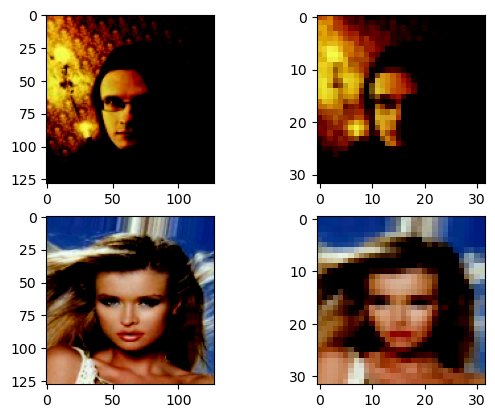

In [43]:
for x,y in (train_loader):
    plt.subplot(2,2,1)
    plt.imshow((x[0]).permute(1,2,0))
    plt.subplot(2,2,2)
    plt.imshow(y[0].permute(1,2,0))
    plt.subplot(2,2,3)
    plt.imshow(x[4].permute(1,2,0))
    plt.subplot(2,2,4)
    plt.imshow(y[4].permute(1,2,0))    
    break

In [44]:
gen=SRGenerator().to('cuda')
disc=critic().to('cuda')

In [45]:
loss=nn.MSELoss()
bce=nn.BCEWithLogitsLoss()
genoptim=optim.Adam(gen.parameters(),lr=0.0001)
discoptim=optim.Adam(disc.parameters(),lr=0.00005)

In [46]:
vggfeat=nn.Sequential(*list(vgg.features.children())[:27]).to('cuda').eval()
vggfeat2=nn.Sequential(*list(vgg.features.children())[:34]).to('cuda').eval()
for p in vggfeat.parameters(): p.requires_grad=False
for p in vggfeat2.parameters(): p.requires_grad=False

In [47]:
_imnet_mean = torch.tensor([0.485,0.456,0.406], device='cuda').view(1,3,1,1)
_imnet_std  = torch.tensor([0.229,0.224,0.225], device='cuda').view(1,3,1,1)
def _vgg_norm(t):
    return (t.clamp(0,1) - _imnet_mean) / _imnet_std

In [48]:
adv_weight = 1e-3  # SRGAN-style small weight on adversarial term
gen.train()
disc.train()
epoch=1

In [50]:
global_step = 0
for i in range(epoch): 
    sample_sr = None   # <-- added: will hold first batch's SR
    sample_y  = None   # <-- added: will hold first batch's HR

    for bidx, (y,x) in enumerate(train_loader):   # <-- enumerate to catch first batch
        # convention: y=HR target, x=LR input
        x=x.to('cuda', non_blocking=True)
        y=y.to('cuda', non_blocking=True)

        # ---------------------
        # 1) Generator forward
        # ---------------------
        sr = gen(x)  # super-res output

        # ---------------------
        # 2) Train Discriminator
        # ---------------------
        discoptim.zero_grad(set_to_none=True)
        with torch.no_grad():
            sr_detached = sr.detach()

        logits_real = disc(y)
        logits_fake = disc(sr_detached)

        real_labels = torch.ones_like(logits_real)
        fake_labels = torch.zeros_like(logits_fake)

        d_loss_real = bce(logits_real, real_labels)
        d_loss_fake = bce(logits_fake, fake_labels)
        d_loss = 0.5*(d_loss_real + d_loss_fake)
        d_loss.backward()
        discoptim.step()

        # ---------------------
        # 3) Train Generator
        # ---------------------
        genoptim.zero_grad(set_to_none=True)

        # VGG feature (perceptual) loss
        sr_n = _vgg_norm(sr)
        y_n  = _vgg_norm(y)

        vgg_sr1 = vggfeat(sr_n)
        vgg_y1  = vggfeat(y_n)
        vgg_sr2 = vggfeat2(sr_n)
        vgg_y2  = vggfeat2(y_n)

        l1 = loss(vgg_sr1, vgg_y1)
        l2 = loss(vgg_sr2, vgg_y2)
        perceptual = 0.5*(l1 + l2)

        # generator adversarial loss (want disc(sr) -> real)
        logits_fake_for_g = disc(sr)
        g_adv = bce(logits_fake_for_g, torch.ones_like(logits_fake_for_g))

        g_loss = perceptual + adv_weight * g_adv
        g_loss.backward()
        genoptim.step()

        # --- capture first batch for epoch preview (SR/HR) ---
        if bidx == 0 and sample_sr is None:
            sample_sr = sr[:5].detach().clamp(0,1).cpu()
            sample_y  = y[:5].detach().clamp(0,1).cpu()

        # optional: quick log
        if global_step % 50 == 0:
            print(f"ep {i} step {global_step}: D={d_loss.item():.4f} (r {d_loss_real.item():.4f} f {d_loss_fake.item():.4f}) | "
                  f"G={g_loss.item():.4f} (perc {perceptual.item():.4f} adv {g_adv.item():.4f})")
        global_step += 1 

    # ---- end of epoch: save grids (first 5 SR & HR) ----
    if sample_sr is not None and sample_y is not None:
        grid_sr = make_grid(sample_sr, nrow=5, padding=2)
        grid_hr = make_grid(sample_y, nrow=5, padding=2)
        save_image(grid_sr, os.path.join(save_dir, f"epoch_{i:04d}_SR.png"))
        save_image(grid_hr, os.path.join(save_dir, f"epoch_{i:04d}_HR.png"))

ep 0 step 0: D=0.7695 (r 0.8879 f 0.6511) | G=4.1403 (perc 4.1042 adv 36.1429)
ep 0 step 50: D=0.0000 (r 0.0000 f 0.0000) | G=3.3051 (perc 3.2718 adv 33.2882)
ep 0 step 100: D=0.0000 (r 0.0000 f 0.0000) | G=2.4064 (perc 2.3465 adv 59.9121)
ep 0 step 150: D=0.0546 (r 0.0000 f 0.1092) | G=2.3567 (perc 2.3277 adv 28.9953)
ep 0 step 200: D=0.0000 (r 0.0000 f 0.0000) | G=2.0558 (perc 2.0100 adv 45.7558)
ep 0 step 250: D=0.0000 (r 0.0000 f 0.0000) | G=2.0961 (perc 2.0548 adv 41.3526)
ep 0 step 300: D=0.0135 (r 0.0003 f 0.0268) | G=1.8334 (perc 1.7908 adv 42.6774)
ep 0 step 350: D=0.0006 (r 0.0000 f 0.0012) | G=1.7945 (perc 1.7406 adv 53.9343)
ep 0 step 400: D=0.0207 (r 0.0414 f 0.0000) | G=1.7017 (perc 1.6424 adv 59.2491)
ep 0 step 450: D=0.0029 (r 0.0028 f 0.0030) | G=1.7306 (perc 1.6758 adv 54.8068)
ep 0 step 500: D=0.0003 (r 0.0006 f 0.0000) | G=1.5672 (perc 1.5260 adv 41.2344)
ep 0 step 550: D=0.2441 (r 0.4882 f 0.0000) | G=1.5525 (perc 1.5129 adv 39.6256)
ep 0 step 600: D=0.0006 (r 0.00

KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.89873487..0.9600475].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99307096..0.9980533].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.05668..0.9818293].


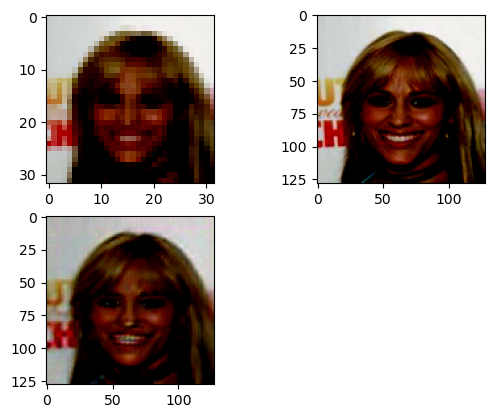

In [68]:
for x,y in train_loader:
    plt.subplot(2,2,1)
    plt.imshow(y[0].permute(1,2,0))
    plt.subplot(2,2,2)
    plt.imshow(x[0].permute(1,2,0))
    ha=gen(y.to('cuda')).detach()
    plt.subplot(2,2,3)
    ha=ha.to('cpu')
    plt.imshow(ha[0].permute(1,2,0))
    grid_sr = make_grid(ha, nrow=7, padding=2)
    grid_hr = make_grid(x, nrow=7, padding=2)
    grid_lr=make_grid(y,nrow=7,padding=2)
    save_image(grid_sr, os.path.join(save_dir, f"epoch_SuperRes{i:04d}_SR.png"))
    save_image(grid_hr, os.path.join(save_dir, f"epoch_HighReS{i:04d}_HR.png"))
    save_image(grid_lr, os.path.join(save_dir, f"epoch_LowREs{i:04d}_HR.png"))
    
    break